# Digit Generation

Train a generative adversarial network (GAN) to generate realistic handwritten digits similar to those in the MNIST dataset.

In [1]:
# Importing necessary libraries for PyTorch and data visualization
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms

# Setting a random seed for reproducibility
random_seed = 1
torch.backends.cudnn.enabled = False  # Disabling CuDNN for deterministic results
_ = torch.manual_seed(random_seed)  # Setting manual seed for random number generation

In [2]:
# Create useful folders
folders = ["../data", "../results/", "../results/digit-generation/"]
for f in folders:
    if not os.path.exists(f):
        os.mkdir(f)

In [3]:
# Defining batch sizes for training and testing data
batch_size_train = 64
batch_size_test = 1000

# Defining data transformations, including converting images to tensors and normalizing pixel values
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Loading MNIST dataset for training and testing
# For training data, setting train=True, downloading if not available, and applying transformations
train_dataset = datasets.MNIST("../data", train=True, download=True, transform=transform)

# For testing data, setting train=False, not downloading, and applying transformations
train_dataset = datasets.MNIST("../data", train=False, transform=transform)

# Creating data loaders for efficient batch processing during training and testing
# For training data, using DataLoader with specified batch size and shuffling the data
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True
)

# For testing data, using DataLoader with specified batch size and shuffling the data
test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_test, shuffle=True
)

Shape of example_data: torch.Size([1000, 1, 28, 28])


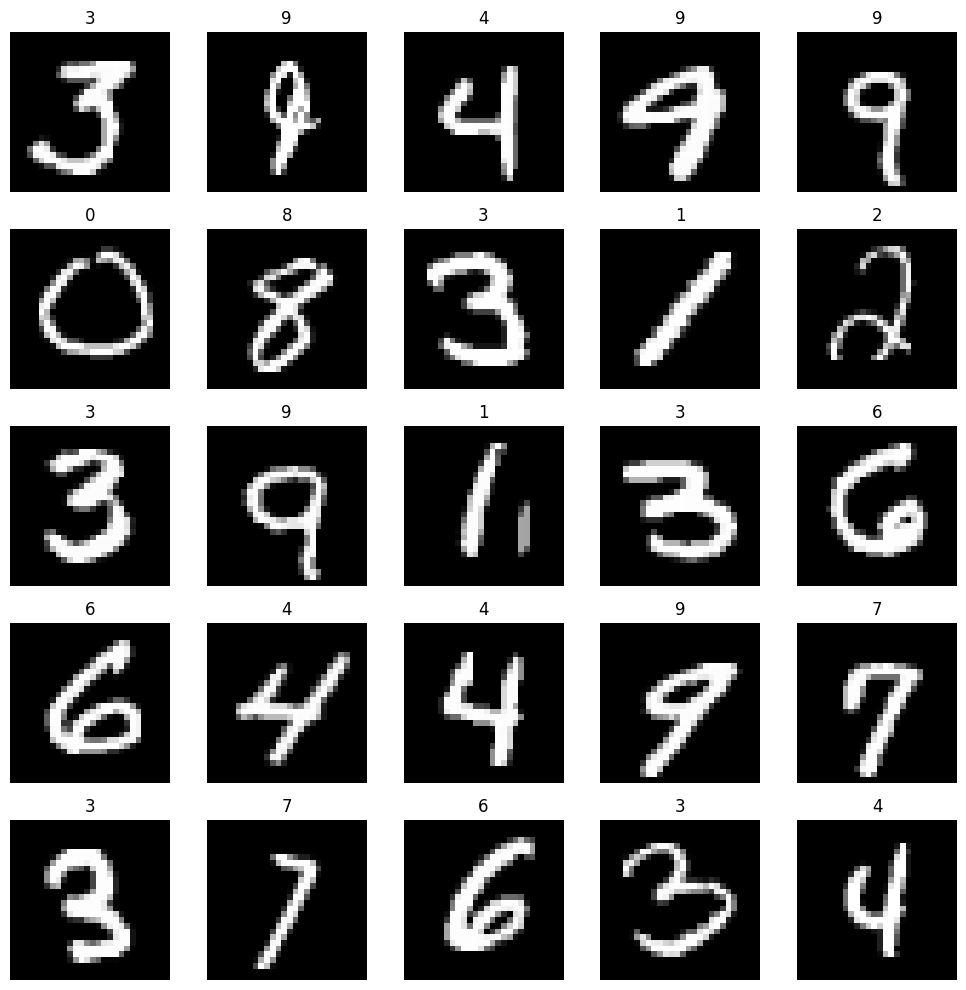

In [4]:
# Getting one batch of examples from the test_loader
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

# Printing the shape of the example_data tensor
print("Shape of example_data:", example_data.shape)

# Plotting the first images along with their labels
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_data[i][0], cmap="gray", interpolation="none")
    ax.set_title("{}".format(example_targets[i]))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
z_dim = 100
G = Generator(z_dim)
D = Discriminator()

print(G)
print(D)

Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [7]:
from torch.utils.tensorboard import SummaryWriter
import shutil

# Path to the log directory
log_dir = "./runs/digit-generation/generator"

# Remove the previous log directory (if it exists)
shutil.rmtree(log_dir, ignore_errors=True)

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Visualize the network architecture
dummy_input = torch.rand(1, z_dim)  # Create a dummy input tensor
writer.add_graph(G, dummy_input)

# Path to the log directory
log_dir = "./runs/digit-generation/discriminator"

# Remove the previous log directory (if it exists)
shutil.rmtree(log_dir, ignore_errors=True)

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Visualize the network architecture
dummy_input = torch.rand(1, 1, 28, 28)  # Create a dummy input tensor
writer.add_graph(D, dummy_input)

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
D_optimizer = optim.Adam(D.parameters(), lr=0.0002)
G_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [9]:
def generator_train(batch_size):
    # Reset gradients
    G_optimizer.zero_grad()

    # Generate random noise
    z = torch.randn(batch_size, z_dim)

    # Generate fake data with the generator
    fake_data = G(z)

    # Labels for the generated data
    fake_labels = torch.ones(batch_size, 1)

    # Pass the generated data through the discriminator
    D_output = D(fake_data)

    # Calculate the generator loss
    G_loss = criterion(D_output, fake_labels)

    # Backpropagation and optimization
    G_loss.backward()
    G_optimizer.step()

    return G_loss.item()


def discriminator_train(real_data, batch_size):
    # Reset gradients
    D_optimizer.zero_grad()

    # Labels for the real and fake data
    real_labels = torch.ones(batch_size, 1)
    fake_data = G(torch.randn(batch_size, z_dim))
    fake_labels = torch.zeros(batch_size, 1)

    # Pass the real and fake data through the discriminator
    D_real_output = D(real_data)
    D_fake_output = D(fake_data.detach())  # Detach fake_data

    # Calculate the discriminator loss for real and fake data
    D_real_loss = criterion(D_real_output, real_labels)
    D_fake_loss = criterion(D_fake_output, fake_labels)

    # Total discriminator loss
    D_loss = D_real_loss + D_fake_loss

    # Backpropagation and optimization
    D_loss.backward()
    D_optimizer.step()

    return D_loss.item()

In [10]:
# Nombre d'époques
num_epochs = 20

# Boucle d'entraînement
D_losses, G_losses = [], []
for epoch in range(1, num_epochs + 1):
    # Boucle pour entraîner le générateur et le discriminateur à chaque batch
    for i, (real_data, _) in enumerate(train_loader):
        # Taille du batch
        batch_size = real_data.size(0)

        # Entraîner le générateur
        generator_loss = generator_train(batch_size)
        G_losses.append(generator_loss)

        # Entraîner le discriminateur
        discriminator_loss = discriminator_train(
            real_data.view(-1, 784), batch_size
        )
        D_losses.append(discriminator_loss)

        # Affichage des informations d'entraînement
        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], Batch [{i}/{len(train_loader)}], generator_loss: {torch.mean(torch.FloatTensor(G_losses)):.4f}, discriminator_loss: {torch.mean(torch.FloatTensor(D_losses)):.4f}"
            )
    print(
        f"\n\t\t===> Epoch {epoch}, G-Loss: {torch.mean(torch.FloatTensor(G_losses)):.4f}, D-Loss: {torch.mean(torch.FloatTensor(D_losses)):.4f}\n"
    )

Epoch [1/5], Batch [0/157], generator_loss: 0.6545, discriminator_loss: 1.4009
Epoch [1/5], Batch [100/157], generator_loss: 1.7182, discriminator_loss: 0.9959

		===> Epoch 1, G-Loss: 1.8383, D-Loss: 1.0628

Epoch [2/5], Batch [0/157], generator_loss: 1.8313, discriminator_loss: 1.0624
Epoch [2/5], Batch [100/157], generator_loss: 1.7470, discriminator_loss: 1.0692

		===> Epoch 2, G-Loss: 1.7049, D-Loss: 1.1385

Epoch [3/5], Batch [0/157], generator_loss: 1.7010, discriminator_loss: 1.1394
Epoch [3/5], Batch [100/157], generator_loss: 1.6152, discriminator_loss: 1.0878

		===> Epoch 3, G-Loss: 1.5923, D-Loss: 1.0469

Epoch [4/5], Batch [0/157], generator_loss: 1.5941, discriminator_loss: 1.0458
Epoch [4/5], Batch [100/157], generator_loss: 2.2135, discriminator_loss: 0.9728

		===> Epoch 4, G-Loss: 2.6148, D-Loss: 0.8987

Epoch [5/5], Batch [0/157], generator_loss: 2.6206, discriminator_loss: 0.8973
Epoch [5/5], Batch [100/157], generator_loss: 3.4163, discriminator_loss: 0.7754

		=

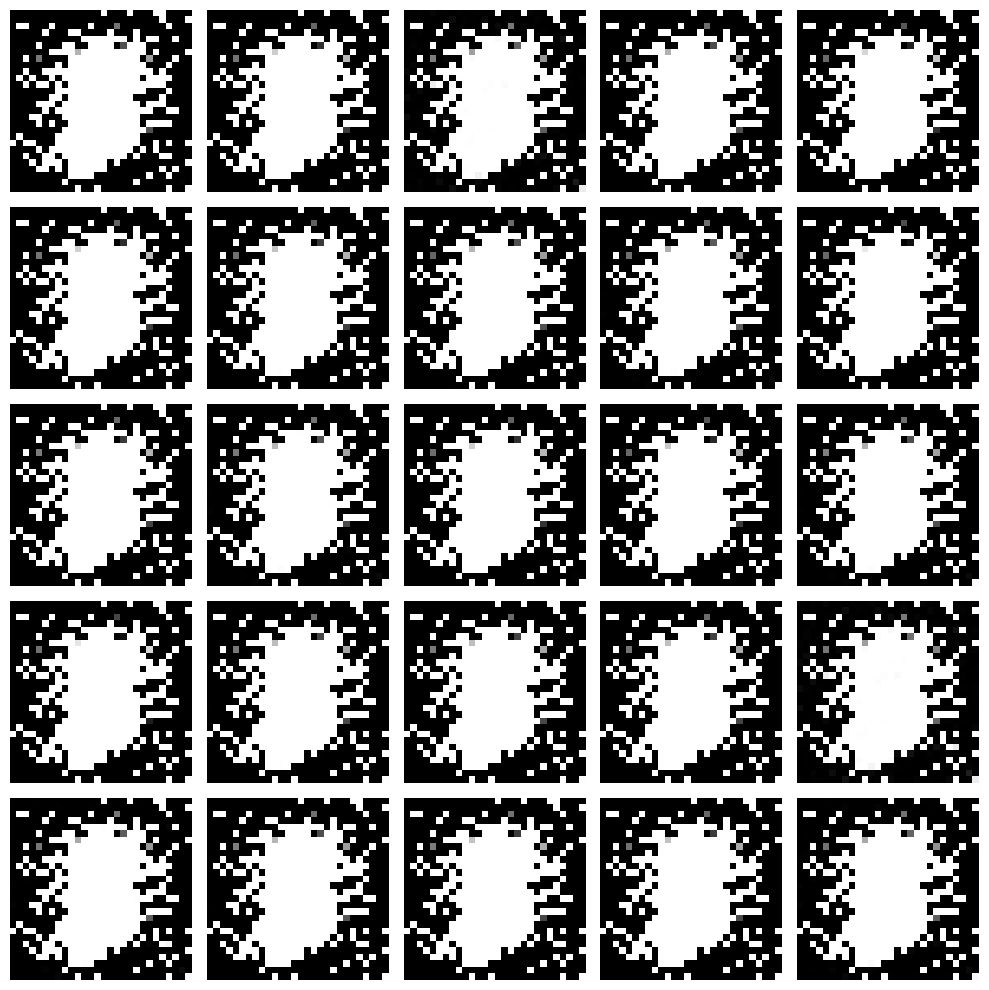

In [11]:
# Définir le nombre de colonnes et de lignes pour afficher les images
n_rows = 5
n_cols = 5

# Créer une nouvelle figure avec une grille de sous-graphiques
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Désactiver le calcul des gradients
with torch.no_grad():
    # Générer des images avec le générateur
    test_z = torch.randn(n_rows * n_cols, z_dim)
    generated = G(test_z).detach()

    # Itérer sur chaque image générée et l'afficher dans un sous-graphique
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated[i].view(28, 28), cmap='gray')
        ax.axis('off')

# Afficher la figure
plt.tight_layout()
plt.show()